# 시계열 분석 연습문제

## 패키지

In [1]:
import pyupbit
import datetime as dt
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb
from pandas import read_excel, to_datetime

import sys
sys.path.append("../../../")
from helper import set_datetime_index, exp_time_data

# 문제 1

다음의 데이터는 1937년 07월 01일부터 2023년 08월 06일까지 서울의 평균 기온을 조사한 자료의 일부이다.

이 데이터를 활용하여 조사기간동안 서울의 평균기온이 어떻게 변화하고 있는지 ARIMA와 AUTO_ARIMA를 사용하여 분석하고 앞으로 1년간의 평균 기온을 시각화.

시각화 기간은 2023년 8월 6일을 기준으로 전후 1년간으로 한다.

In [2]:
origin = read_excel("https://data.hossam.kr/E06/temperatures_seoul.xlsx")
origin.head()

,날짜,평균기온(℃)
0,1973-07-01,22.7
1,1973-07-02,23.8
2,1973-07-03,27.2
3,1973-07-04,25.2
4,1973-07-05,26.9


## 데이터 전처리

In [3]:
origin.info()
origin.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18299 entries, 0 to 18298
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   날짜       18299 non-null  datetime64[ns]
 1   평균기온(℃)  18299 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 286.0 KB


날짜         datetime64[ns]
평균기온(℃)           float64
dtype: object

In [4]:
df = origin.copy()
df.head()

,날짜,평균기온(℃)
0,1973-07-01,22.7
1,1973-07-02,23.8
2,1973-07-03,27.2
3,1973-07-04,25.2
4,1973-07-05,26.9


In [5]:
df.isna().sum()

날짜         0
평균기온(℃)    0
dtype: int64

In [6]:
df1 = set_datetime_index(df, '날짜')
df1.head()

,평균기온(℃)
1973-07-01,22.7
1973-07-02,23.8
1973-07-03,27.2
1973-07-04,25.2
1973-07-05,26.9


## 데이터 검정

In [7]:
# 데이터가 상승 값이면 곱셈 방식으로 "m"
# 데이터가 하강 값이면 덧셈 방식으로 "a"
# max_diff로 최대 차분 횟수 설정
# exp_time_data(df, 'Passengers', "m", max_diff=10)

결측치 수: 0


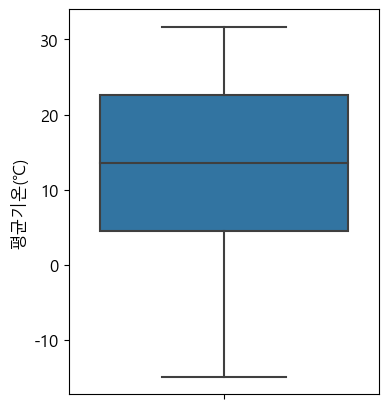

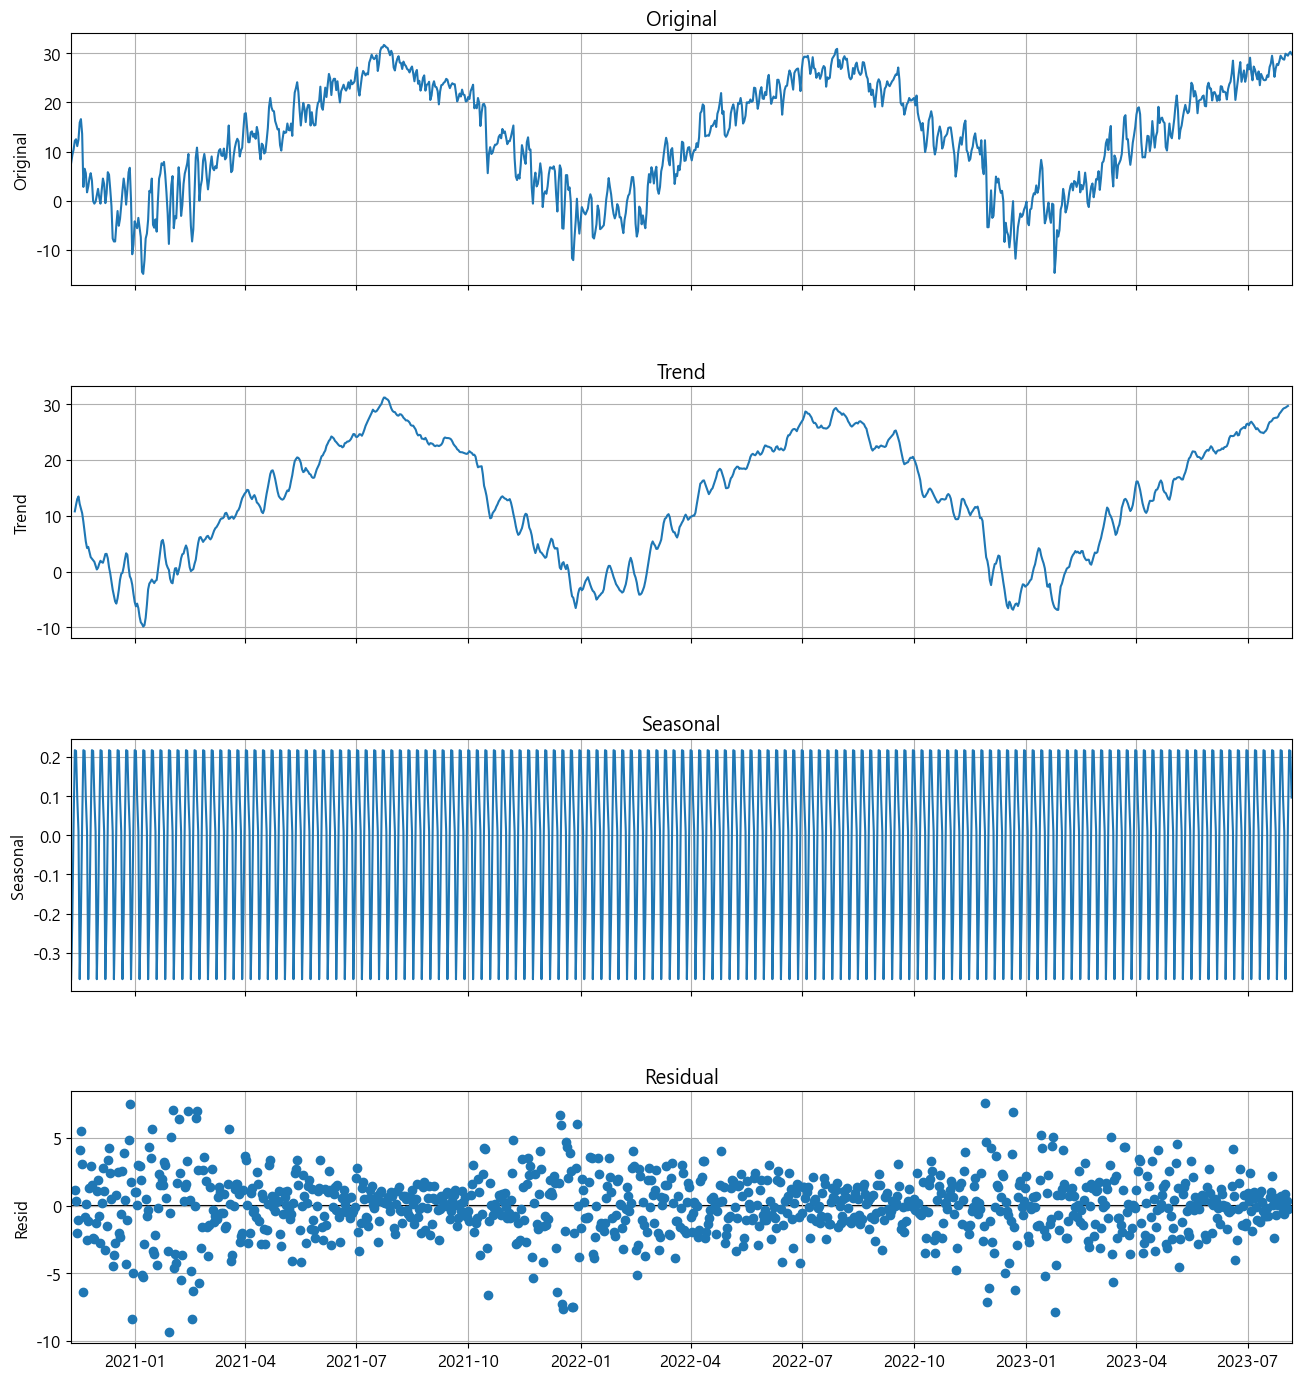

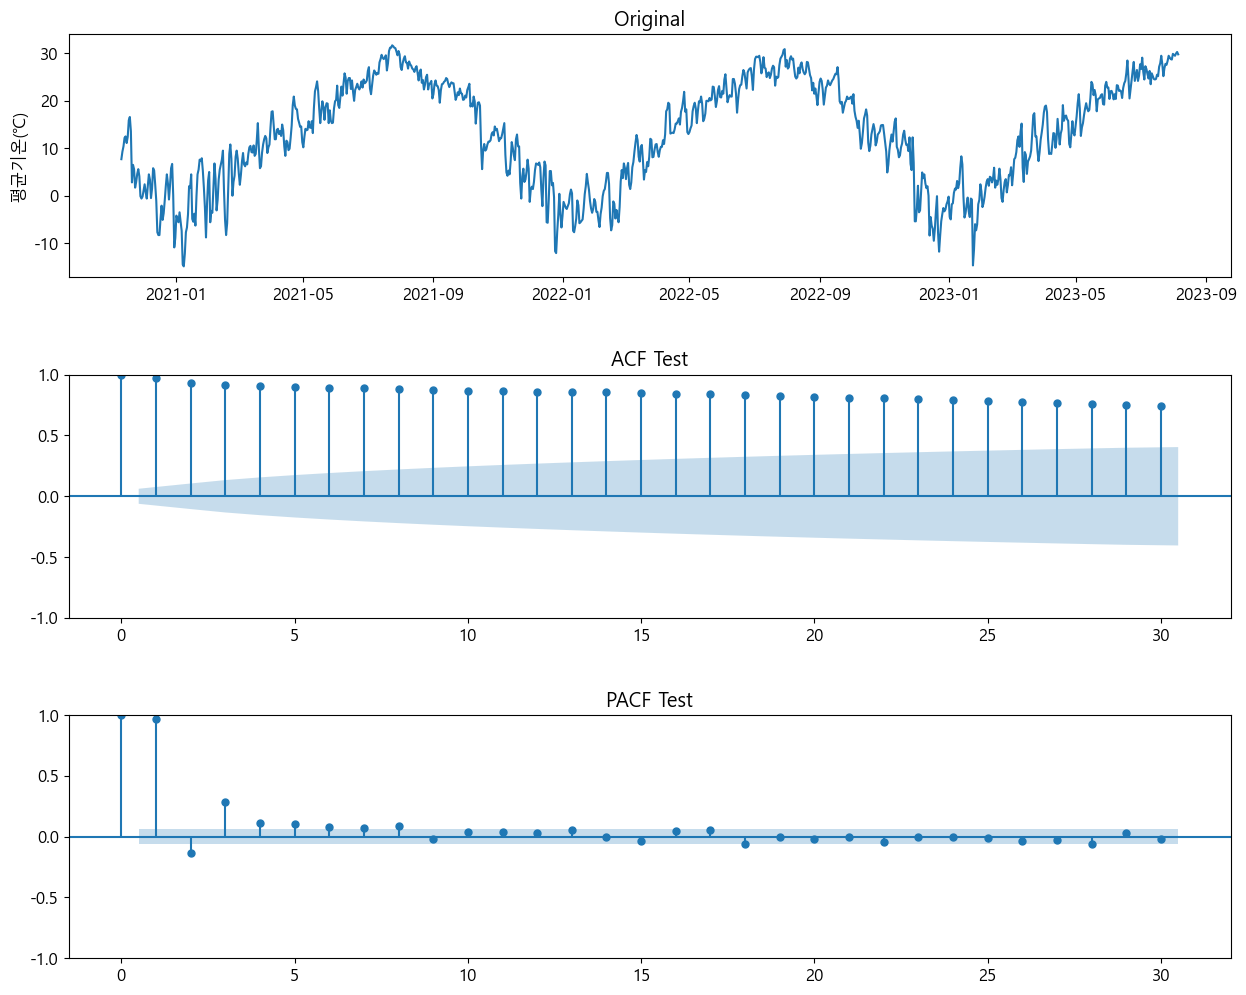

=========== 원본 데이터 ===========
+------------------------------------+----------+
| ADF Test                           |          |
|------------------------------------+----------|
| 검정통계량(ADF Statistic)          | -1.19544 |
| 유의수준(p-value)                  | 0.675556 |
| 최적차수(num of lags)              |       17 |
| 관측치 개수(num of observations)   |      982 |
| 기각값(Critical Values) 1%         | -3.43703 |
| 기각값(Critical Values) 5%         | -2.86449 |
| 기각값(Critical Values) 10%        | -2.56834 |
| 데이터 정상성 여부(0=False,1=True) |        0 |
+------------------------------------+----------+
=========== 1차 차분 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -9.66751 |
| 유의수준(p-value)                  | 1.30325e-16 |
| 최적차수(num of lags)              |          16 |
| 관측치 개수(num of observations)   |         982 |
| 기각값(Critical Va

In [8]:
exp_time_data(data=df1.tail(1000), yname="평균기온(℃)", sd_model="a",max_diff=10)

### #`ACF, PACF 검정 기준`

| 구분 | $AR(p)$ 모델 적합 | $MA(q)$ 모델 적합 |
|---|---|---|
| ACF plot | 천천히 감소 | 첫 값으로부터 $q$개 뒤에 끊긴다. |
| PACF plot | 첫 값으로부터 $p$개 뒤에 끊긴다. | 천천히 감소 |

`추가` - 쉬운 설명
| 구분 | ACF plot | PACF plot |
|---|---|---|
| 감소 | 상대적으로 완만 | 상대적으로 급격 |
| 파란박스 진입 지점 | $p=1$ | $q=1$ |
| 적합 모델 | $AR(p)$ 모델 적합 | $MA(q)$ 모델 적합 |


계절성 고려 -> seasonal_order=(P,D,Q,s) - 계절성이란 주기

여기서는 일단위 데이터이므로 1년 주기로 보고 주기는 365로 설정

계절성은 분석가가 직접 판단 - 여러번 도전(반 노가다)

### 중간 분석

계절성(주기)는 365일로 지정

## 모델 구축

In [9]:
# # 함부로 주기를 365로 설정하고 돌리지 말것 - PC가 죽음
# model = ARIMA(df1.tail(1000)['평균기온(℃)'], order=(1,0,0), seasonal_order=(1,1,0,365))
# fit = model.fit()
# print(fit.summary())